In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import json
import glob
import random
import shutil
import warnings
from collections import Counter
import plotly
import seaborn as sns
import cv2

In [5]:
cwd = os.getcwd()
print(cwd)
os.chdir(r'C:\Users\v-kumardeep\Desktop\cassava-leaf-disease-classification')
cwd = os.getcwd()
print(cwd)

C:\Users\v-kumardeep
C:\Users\v-kumardeep\Desktop\cassava-leaf-disease-classification


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    print('Yes, there is GPU')
    
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0
Yes, there is GPU


In [4]:
data = pd.read_csv('train.csv')

with open('label_num_to_disease_map.json') as f:
    labels = json.load(f)
    labels = {int(k):v for k,v in labels.items()}
    
data['class_name'] = data['label'].map(labels)

labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [5]:
data.head(5)

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size =0.05, random_state = 42, stratify = data['class_name'])

In [7]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

train_data = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

test_data = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)


train_set = train_data.flow_from_dataframe(
    train,
    directory='train_images',
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = (456,456),
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = 15
)

test_set = test_data.flow_from_dataframe(
    test,
    directory='train_images',
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = (456,456),
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size= 15    
)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [9]:
model = Sequential()
model.add(
    EfficientNetB3(
        input_shape = (456, 456, 3), 
        include_top = False,
        weights='imagenet',
        drop_connect_rate=0.6,
    )
)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(
    256, 
    activation='relu', 
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 15, 15, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                        

In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits = False,
    label_smoothing=0.0001,
    name='categorical_crossentropy'
)

model.compile(
    optimizer = Adam(learning_rate = 1e-3),
    loss = loss, #'categorical_crossentropy'
    metrics = ['categorical_accuracy']
)

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=3,
    restore_best_weights=True, 
    verbose=1,
)
checkpoint_cb = ModelCheckpoint(
    "Cassava_best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr= 1e-6,
    mode='min',
    verbose=1,
)

history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=15,
    batch_size=15,
    steps_per_epoch=train_set.n // train_set.batch_size,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=[es, checkpoint_cb, reduce_lr],
)

model.save('Cassava_model'+'.h5')

Epoch 1/15
1355/1355 [==============================] - ETA: 0s - loss: 0.7058 - categorical_accuracy: 0.7579 

C:\Users\v-kumardeep\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1355/1355 [==============================] - 28488s 21s/step - loss: 0.7058 - categorical_accuracy: 0.7579 - val_loss: 0.4804 - val_categorical_accuracy: 0.8423 - lr: 0.0010
Epoch 2/15
1355/1355 [==============================] - 29637s 22s/step - loss: 0.5576 - categorical_accuracy: 0.8158 - val_loss: 0.5884 - val_categorical_accuracy: 0.8113 - lr: 0.0010
Epoch 3/15
1355/1355 [==============================] - ETA: 0s - loss: 0.5140 - categorical_accuracy: 0.8270 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1355/1355 [==============================] - 29192s 22s/step - loss: 0.5140 - categorical_accuracy: 0.8270 - val_loss: 0.4958 - val_categorical_accuracy: 0.8460 - lr: 0.0010
Epoch 4/15
1355/1355 [==============================] - 27077s 20s/step - loss: 0.4215 - categorical_accuracy: 0.8623 - val_loss: 0.3594 - val_categorical_accuracy: 0.8826 - lr: 2.0000e-04
Epoch 5/15
1355/1355 [==============================] - 28649s 21s/step - loss: 0.3889

In [16]:
print('Train Categorical Accuracy: ', max(history.history['categorical_accuracy']))
print('Test Categorical Accuracy: ', max(history.history['val_categorical_accuracy']))

Train Categorical Accuracy:  0.8946927785873413
Test Categorical Accuracy:  0.8892018795013428


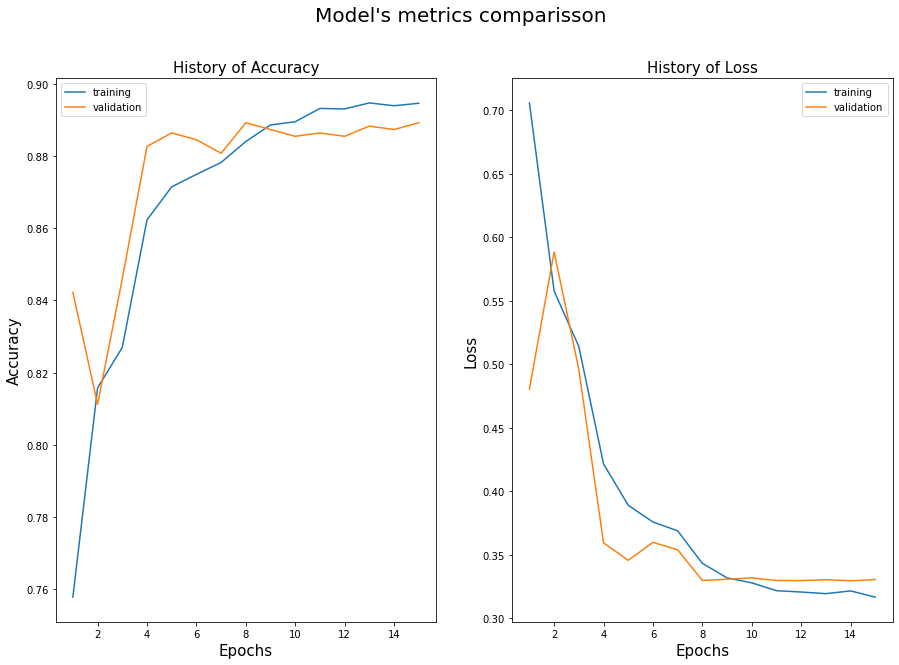

In [15]:
def trai_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Model's metrics comparisson", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

train_test_plot(
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    history.history['loss'],
    history.history['val_loss']
)

In [6]:
final_model = keras.models.load_model('Cassava_model.h5')

In [7]:
from PIL import Image

TEST_DIR = 'test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    img = Image.open(TEST_DIR + image)
    img = img.resize((456,456))
    img = np.expand_dims(img, axis=0)
    predictions.extend(final_model.predict(img).argmax(axis = 1))

In [8]:
predictions

[4]

In [9]:
class_dict = {"Cassava_Bacterial_Blight" : 0,
           "Cassava_Brown_Streak_Disease" : 1,
           "Cassava_Green_Mottle":2,
           "Cassava_Mosaic_Disease" : 3,
           "Healthy": 4}

In [10]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))